# Homework 1
In this homework, we will have you train some convolutional neural networks! We will start with a small dataset (CIFAR), and then work our way up to TinyImageNet! This homework originally written by Daniel Gordon with very minor modifications.

# Initial Setup

This will authenticate Colab to connect to your google drive account. This way you have space to store the datasets and won't have to redownload them every time. You'll also have stable storage to save your best performing networks.

In [1]:
from google.colab import drive
drive.mount('/gdrive/')
!ls /gdrive

Mounted at /gdrive/
MyDrive  Shareddrives


Run this code to navigate to the BASE_PATH directory and upload the homework2.tar file inside the BASE_PATH, then extract it.

Have a look at [pt_util](https://gist.github.com/pjreddie/e531394d779af2da9201096af0dba78a). We moved some of the useful functions out of the python notebook to make it less cluttered, and added a few more useful functions.

I made the BASE_PATH and DATA_PATH variables so you don't have to copy the same strings all over the place if you want to move the locations of the files around.

In [2]:
import os

BASE_PATH = '/gdrive/My Drive/colab_files/hw1/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'train.h5'):
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework2.tar
    !tar -xvf homework2.tar
    !rm homework2.tar
!pwd
!ls
os.chdir('/content')

/content
sample_data
/gdrive/My Drive/colab_files/hw1
cifar  pt_util.py  __pycache__	tiny_imagenet


# CIFAR

## Part 1: Getting the Dataset
Normally, we'd want to download our dataset first. Since PyTorch hosts the CIFAR dataset, we can load it using their helper function later.

But, we'll change DATA_PATH to an empty directory to download the dataset to.

In [ ]:
DATA_PATH = BASE_PATH + 'cifar/'

## Part 2: Defining the Network
Just like with MNIST last homework we need to define our network architecture. This time we will be using convolutional layers and maxpooling to extract features from our images before we feed those features into our final classifier.

Check out the documentation for [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html):

    nn.Conv2d(in_channels, out_channels, kernel_size, stride = 1, padding = 0,...)

So the first parameter is the number of channels in the input. Second is the number of filters we'll use (AKA number of channels in the output). Third is kernel size. Next is stride and padding which are optional and have default values.

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util

In [ ]:
class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.accuracy = None

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


This time we are giving you the train and test functions, but feel free to modify them if you want. 

You may need to return some additional information for the logging portion of this assignment.


In [ ]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return test_loss, test_accuracy

## Part 3 and 4: Loading Data and Dataset Augmentation

In the MNIST assignment, we didn't do any data augmentation because MNIST is kind of easy.

In this assignment, you may find that data augmentation helps you a lot (or possibly hurts your performance).

You can find a bunch preimplemented here https://pytorch.org/docs/stable/torchvision/transforms.html and you can also do your own as seen in the tutorial from part 3.

Play around with various data augmentations we will suggest some.

- ToPILImage - This one is useful for a lot of the built in transforms which expect PIL images. 
- RandomHorizontalFlip
- RandomResizedCrop
- ColorJitter
- RandomRotation
- Normalize
- Adding various types of noise
- ToTensor - PyTorch expects the output from the dataset to be a tensor in CxHxW format.


Note: You should be careful about which of these you apply to the test data. You usually don't want to apply noise to the test data, but you do want to normalize it in the same way for example.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

data_train = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)
data_test = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


## Part 5: Training the network
Generally, it is useful to see how your training is going. Often people print their loss to make sure it goes down and their accuracy to make sure it goes up. But pictures are better than words. So for this part, you should record and plot the training loss, test loss, and test accuracy (and whatever else you want). 

We have created a very simple logging interface which essentially just saves and restores files via pickle in pt_util. Saving and restoring log data is important if you end your run early and want to continue where you left off rather than starting over.

We have also provided a plot function which can plot a single line graph. You can use it and plot each value independently, or change it to plot them all in one graph. 

Try different network architectures and experiment with hyperparameters. You'll answer the questions at the bottom of the file based on these experiments.


__Important note: Do not forget to title your graphs and label your axes. Plots are meaningless without a way to read them.__

Second Note: It will be helpful for you when deciding what network structure, data augmentation, and such work to title the graphs accordingly so you remember.

Third Note: The default setup right now saves and restores the network weights from a single folder. When you modify network architectures, you may want to increment your experiment version number so you start over with your training and log files.

BELOW IS THE TRAINING AND THE VISUALIZATION OF IMPORTANT METRICS OF THE BEST PERFORMING MODEL ON THE CIFAR TASK

Using device cuda
num cpus: 2

Test set: Average loss: 2.3042, Accuracy: 1000/10000 (10%)

Sat Oct 30 22:06:08 2021 Train Epoch: 0 [0/50000 (0%)]	Loss: 2.310762
Sat Oct 30 22:06:15 2021 Train Epoch: 0 [25600/50000 (51%)]	Loss: 2.089213

Test set: Average loss: 1.8765, Accuracy: 3163/10000 (32%)

Saved /gdrive/My Drive/colab_files/hw1/cifar/logs/0.12/000.pt

Sat Oct 30 22:06:26 2021 Train Epoch: 1 [0/50000 (0%)]	Loss: 1.970362
Sat Oct 30 22:06:33 2021 Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.784678

Test set: Average loss: 1.6457, Accuracy: 3964/10000 (40%)

Saved /gdrive/My Drive/colab_files/hw1/cifar/logs/0.12/001.pt

Sat Oct 30 22:06:45 2021 Train Epoch: 2 [0/50000 (0%)]	Loss: 1.761023
Sat Oct 30 22:06:51 2021 Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.648559

Test set: Average loss: 1.5327, Accuracy: 4508/10000 (45%)

Saved /gdrive/My Drive/colab_files/hw1/cifar/logs/0.12/002.pt

Sat Oct 30 22:07:02 2021 Train Epoch: 3 [0/50000 (0%)]	Loss: 1.664513
Sat Oct 30 22:07:09 2021 Train E

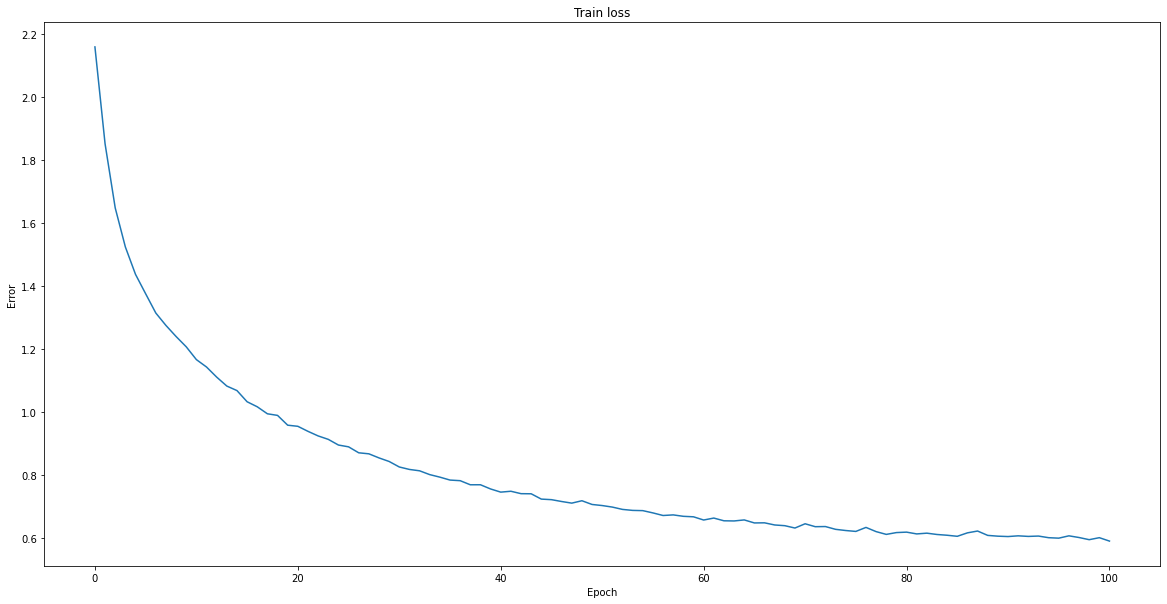

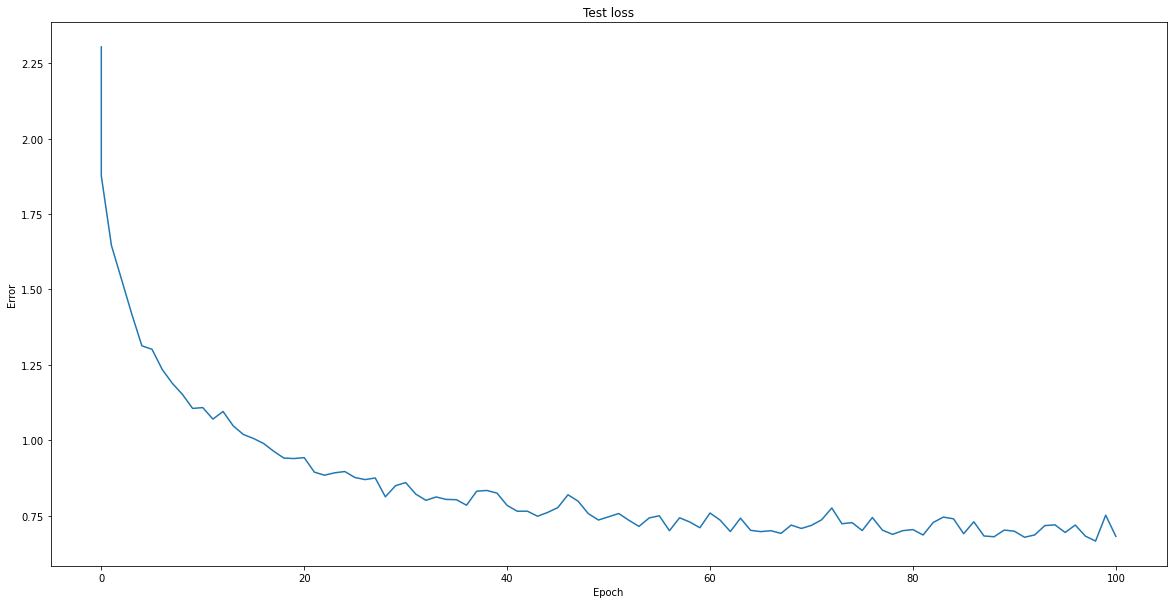

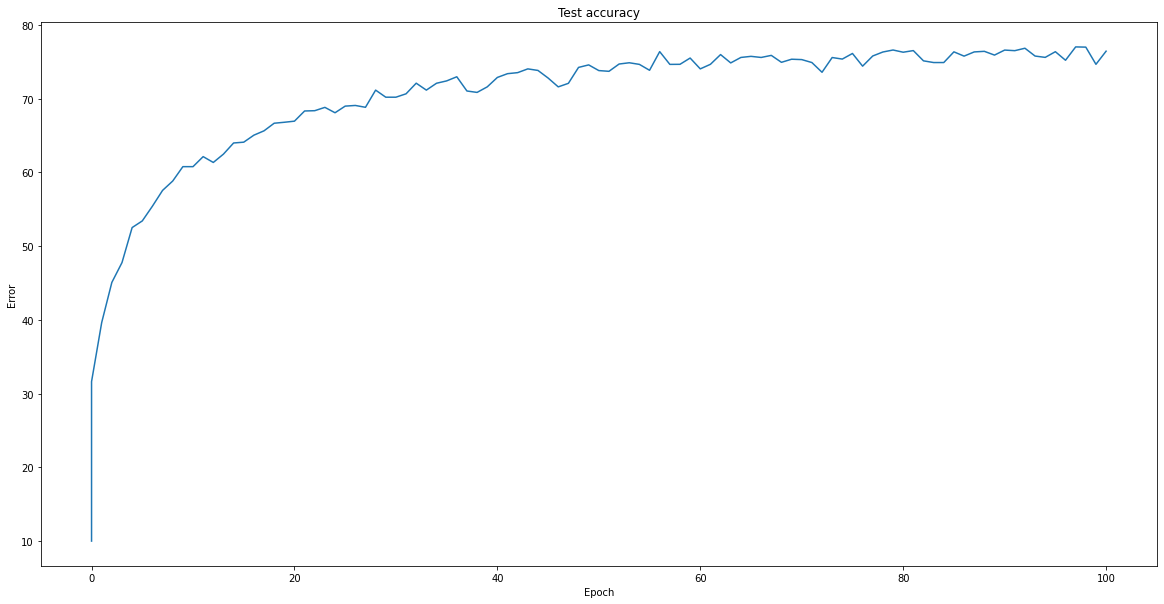

In [ ]:
# Play around with these constants, you may find a better setting.
# Best Model So far
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 100
LEARNING_RATE = 0.05
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005

EXPERIMENT_VERSION = "0.12" # increment this to start a new experiment
LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = CifarNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(LOG_PATH)

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')


In [ ]:
class CifarNetWorst(nn.Module):
    def __init__(self):
        super(CifarNetWorst, self).__init__()
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.accuracy = None

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


BELOW IS THE EXECUTION AND THE GRAPH OF THE IMPORTANT METRICS FOR THE WORST PERFORMING MODEL ON THE CIFAR TASK

Using device cuda
num cpus 2
Restoring:
fc1.weight -> 	torch.Size([512, 3072]) = 6MB
fc1.bias -> 	torch.Size([512]) = 0MB
fc2.weight -> 	torch.Size([128, 512]) = 0MB
fc2.bias -> 	torch.Size([128]) = 0MB
fc3.weight -> 	torch.Size([10, 128]) = 0MB
fc3.bias -> 	torch.Size([10]) = 0MB

Restored all variables
No new variables
Restored /gdrive/My Drive/colab_files/hw1/cifar/logs/worst2/000.pt

Test set: Average loss: 1.8815, Accuracy: 3243/10000 (32%)

Sat Oct 30 23:03:24 2021 Train Epoch: 0 [0/50000 (0%)]	Loss: 1.879747
Sat Oct 30 23:03:27 2021 Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.944046
Sat Oct 30 23:03:31 2021 Train Epoch: 0 [25600/50000 (51%)]	Loss: 2.062375
Sat Oct 30 23:03:34 2021 Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.763389

Test set: Average loss: 1.7942, Accuracy: 3423/10000 (34%)

Saved /gdrive/My Drive/colab_files/hw1/cifar/logs/worst2/000.pt

Sat Oct 30 23:03:42 2021 Train Epoch: 1 [0/50000 (0%)]	Loss: 1.845896
Sat Oct 30 23:03:45 2021 Train Epoch: 1 [12800/50000 (26%)

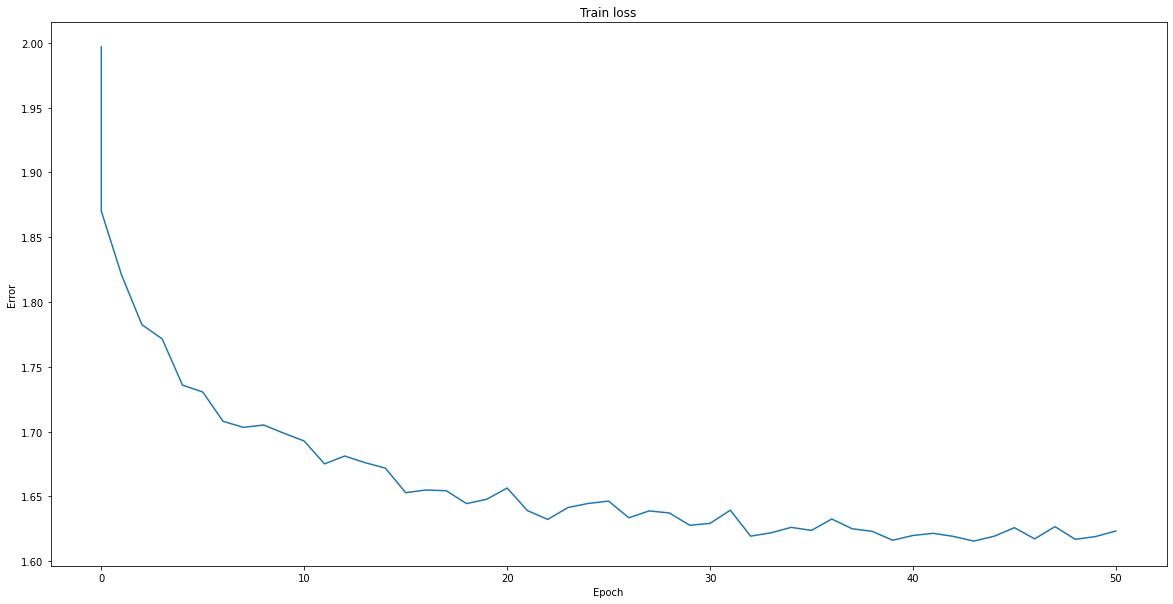

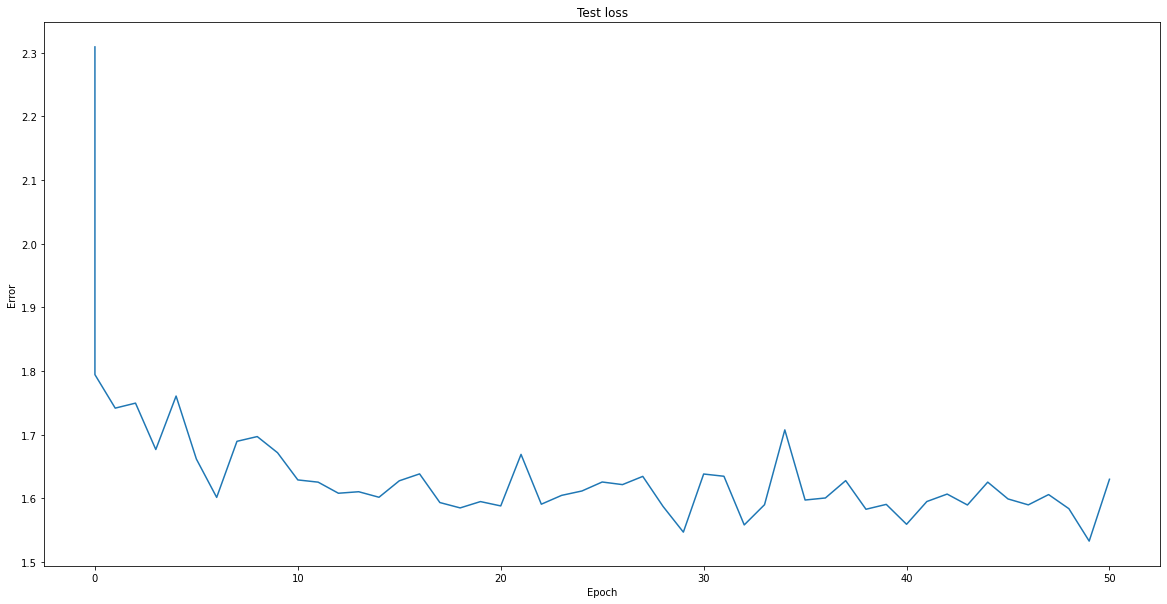

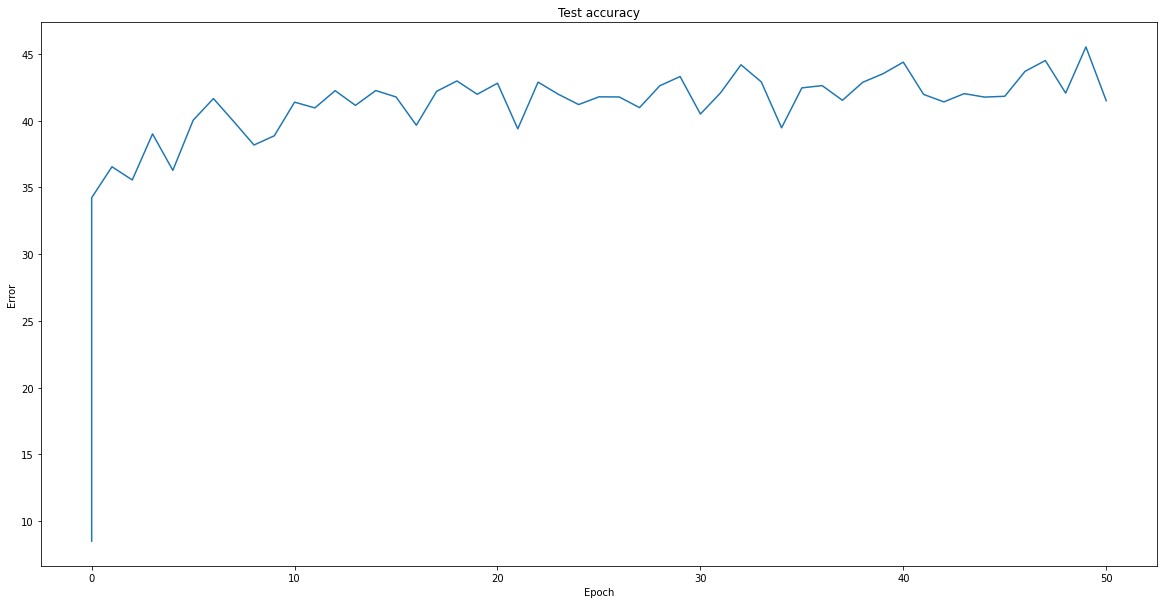

In [ ]:
# TRAINING FOR THE WORST MODEL: BASELINE MNIST WHICH GOT 99%
BATCH_SIZE = 128
TEST_BATCH_SIZE = 10
EPOCHS = 50
LEARNING_RATE = 0.05
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005

EXPERIMENT_VERSION = "worst2" # increment this to start a new experiment
LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = CifarNetWorst().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(LOG_PATH)

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')


##CIFAR Questions

1. What design that you tried worked the best? This includes things like network design, learning rate, batch size, number of epochs, and other optimization parameters, data augmentation etc. What was the final train loss? Test loss? Test Accuracy? Provide the plots for train loss, test loss, and test accuracy.

The design that worked best for me was having 3 conv2d layers as the feature extractor followed by 3 Dense fully connected layer for classification.
After trial and error, the best learning rate that worked for me was 0.05, momentum of 0.9 and decay of 0.0005. The batch size used for 256 and I ran this model for 100 epochs. The final metrics were:

train loss-0.53
test loss-0.68
test accuracy-76%

2. What design worked the worst (but still performed better than random chance)? Provide all the same information as question 1.

So to have a minium baseline required to pass, I figured the best option will be using the model created in the previous homework. So inspired from that, the model that worked the worst was a simple model with 3 dense FC layers, with hyper params:
` ` 
BATCH_SIZE = 128
TEST_BATCH_SIZE = 10
EPOCHS = 50
LEARNING_RATE = 0.05
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005
` ` 
The final metrics were: 

train loss - 1.549869
test loss - 1.6297
test accuracy - 42%

3. Why do you think the best one worked well and the worst one worked poorly.

The biggest difference between the model that performed the best and the model that performed the worst was the network architecture. The best model employed the use of Convolutional layers to help extract important feature, which was then learned and predicted by the fully connected layers. But on the other hand, the second model had just fully connected layers, which were enough to learn mnist features, but fails in this task but the features are much more complicated. So solving this problem would require much more that just fully connected layers, which is exactly what the best model provided us. 


---
# TinyImageNet

## Part 1: Upload the Dataset
Change the DATA_PATH to the path of the TinyImageNet dataset we downloaded earlier.

In [3]:
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

## Part 2: Defining the Network
We're giving you no instructions on this part. Welcome to deep learning research! See if you can get above 40% accuracy. You probably want to use the Cross Entropy error again, but who knows, maybe you can find a better loss function. We will give you a few hints of things to try:

- Maxpooling
- Activation functions other than ReLU
- Batch Norm
- Dropout
- Residual connections

To define your network you'll have to figure out more about the Tiny ImageNet dataset. Specifically, what size are the images you'll be processing? How big is your label space? You can find this out by examining samples of your data.

In [4]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util

In [5]:
# ALEXNETISH
class TinyImagenetNet(nn.Module):
    def __init__(self, in_channels, output_channels):
        super(TinyImagenetNet, self).__init__()
        self.in_channels = in_channels
        self.output_channels = output_channels
        self.accuracy = None
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.6),
            nn.Linear(4096, 1024),
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.6),
            nn.Linear(512, self.output_channels)
        )

        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


In [6]:
# CIFAR NETISH


This time we are giving you the train and test functions, but feel free to modify them if you want. 

You may need to return some additional information for the logging portion of this assignment.


In [7]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, return_images=False, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    correct_images = []
    correct_values = []

    error_images = []
    predicted_values = []
    gt_values = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if return_images:
                if num_correct > 0:
                    correct_images.append(data[correct_mask, ...].data.cpu().numpy())
                    correct_value_data = label[correct_mask].data.cpu().numpy()[:, 0]
                    correct_values.append(correct_value_data)
                if num_correct < len(label):
                    error_data = data[~correct_mask, ...].data.cpu().numpy()
                    error_images.append(error_data)
                    predicted_value_data = pred[~correct_mask].data.cpu().numpy()
                    predicted_values.append(predicted_value_data)
                    gt_value_data = label[~correct_mask].data.cpu().numpy()[:, 0]
                    gt_values.append(gt_value_data)
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))
    if return_images:
        correct_images = np.concatenate(correct_images, axis=0)
        error_images = np.concatenate(error_images, axis=0)
        predicted_values = np.concatenate(predicted_values, axis=0)
        correct_values = np.concatenate(correct_values, axis=0)
        gt_values = np.concatenate(gt_values, axis=0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    if return_images:
        return test_loss, test_accuracy, correct_images, correct_values, error_images, predicted_values, gt_values
    else:
        return test_loss, test_accuracy


## Part 3: Loading Data
PyTorch has a nice interface for dealing with a variety of data. You can read a good tutorial here https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
Your friendly neighborhood TAs have made it even easier by preprocessing the data into a nice format. The data you uploaded is stored using hdf5 files which can be accessed a lot like Numpy arrays using the h5py package. In each of the files, there is a "dataset" called 'images', and one called 'labels'. Read more about h5py here http://docs.h5py.org/en/latest/quick.html

Hints:
1. HDF5s don't support concurrent accesses.
2. If you don't close the HDF5 file, you will still have problems with concurrency.
3. One way to deal with concurrent accesses is to copy the entirety of the data into each process separately. Then each process accesses its own copy of the data. https://stackoverflow.com/questions/40449659/does-h5py-read-the-whole-file-into-memory
4. Speed hint: With small datasets, it is almost always a good idea to cache the data to disk rather than continually read from files.


In [8]:
# Data loader
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, h5_file, transform=None):
        self.transform = transform
        self.h5_file = h5py.File(h5_file, 'r')
        self.images = self.h5_file['images'][:]
        self.labels = torch.LongTensor(self.h5_file['labels'][:])
        
    def __len__(self):
        return self.labels.shape[0]
      
    def __getitem__(self, idx):
        data = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            data = self.transform(data)
        return (data, label)


## Part 4: Dataset Augmentation
In the MNIST assignment, we didn't do any data augmentation because MNIST is kind of easy.

In this assignment, you may find that data augmentation helps you a lot (or possibly hurts your performance).

You can find a bunch preimplemented here https://pytorch.org/docs/stable/torchvision/transforms.html and you can also do your own as seen in the tutorial from part 3.

Play around with various data augmentations we will suggest some.

- ToPILImage - This one is useful for a lot of the built in transforms which expect PIL images. 
- RandomHorizontalFlip
- RandomResizedCrop
- ColorJitter
- RandomRotation
- Normalize
- Adding various types of noise
- ToTensor - PyTorch expects the output from the dataset to be a tensor in CxHxW format.


Note: You should be careful about which of these you apply to the test data. You usually don't want to apply noise to the test data, but you do want to normalize it in the same way for example.


In [9]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

data_train = H5Dataset(DATA_PATH + 'train.h5', transform=train_transforms)
print(len(data_train))
data_test = H5Dataset(DATA_PATH + 'val.h5', transform=test_transforms)
print(len(data_test))


100000
8000


## Part 5: Training the network
Generally, it is useful to see how your training is going. Often people print their loss to make sure it goes down and their accuracy to make sure it goes up. But pictures are better than words. So for this part, you should record and plot the training loss, test loss, and test accuracy (and whatever else you want). 

We have created a very simple logging interface which essentially just saves and restores files via pickle in pt_util. Saving and restoring log data is important if you end your run early and want to continue where you left off rather than starting over.

We have also provided a plot function which can plot a single line graph. You can use it and plot each value independently, or change it to plot them all in one graph. 


__Important note: Do not forget to title your graphs and label your axes. Plots are meaningless without a way to read them.__

Second Note: It will be helpful for you when deciding what network structure, data augmentation, and such work to title the graphs accordingly so you remember.
Third Note: The default setup right now saves and restores the network weights from a single folder. When you modify network architectures, you may want to save the resulting files in different folders (with appropriate names).

We also provided a function for showing some results, because it's not satisfying to train a neural net, you also want to see what it can do! This can also be useful for figuring out what your network is doing well, and what it is failing at. This type of error analysis is very common when training neural networks.


Using device cuda
num cpus: 2


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Test set: Average loss: 5.2988, Accuracy: 38/8000 (0%)



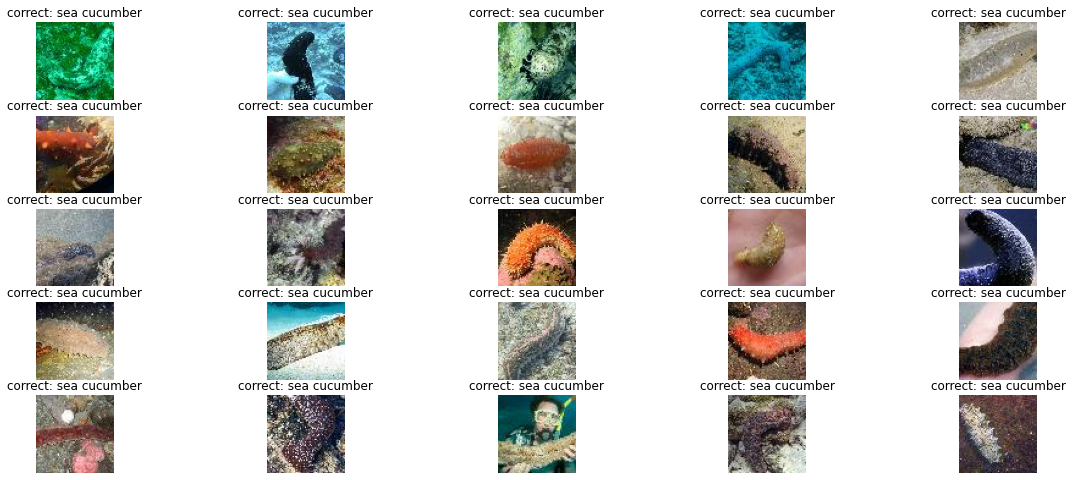

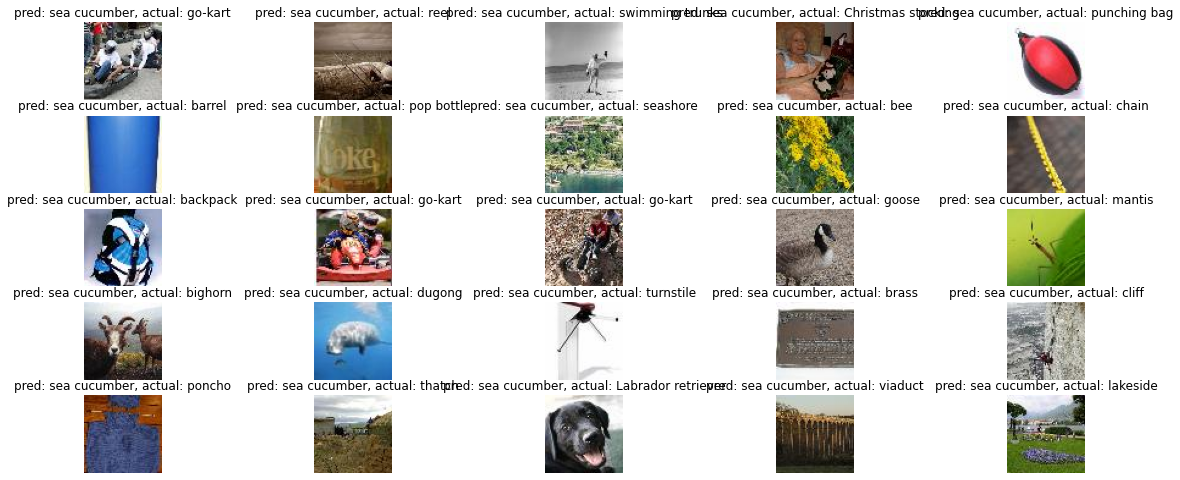

Wed Nov  3 20:12:23 2021 Train Epoch: 0 [0/100000 (0%)]	Loss: 5.303874
Wed Nov  3 20:12:50 2021 Train Epoch: 0 [25600/100000 (26%)]	Loss: 5.300615
Wed Nov  3 20:13:17 2021 Train Epoch: 0 [51200/100000 (51%)]	Loss: 5.290573
Wed Nov  3 20:13:44 2021 Train Epoch: 0 [76800/100000 (77%)]	Loss: 5.256834

Test set: Average loss: 5.2325, Accuracy: 62/8000 (1%)

Saved /gdrive/My Drive/colab_files/hw1/tiny_imagenet/logs/0.17/000.pt

Wed Nov  3 20:14:15 2021 Train Epoch: 1 [0/100000 (0%)]	Loss: 5.280165
Wed Nov  3 20:14:42 2021 Train Epoch: 1 [25600/100000 (26%)]	Loss: 5.134161
Wed Nov  3 20:15:09 2021 Train Epoch: 1 [51200/100000 (51%)]	Loss: 5.166103
Wed Nov  3 20:15:35 2021 Train Epoch: 1 [76800/100000 (77%)]	Loss: 5.084138

Test set: Average loss: 4.9771, Accuracy: 158/8000 (2%)

Saved /gdrive/My Drive/colab_files/hw1/tiny_imagenet/logs/0.17/001.pt

Wed Nov  3 20:16:07 2021 Train Epoch: 2 [0/100000 (0%)]	Loss: 4.957078
Wed Nov  3 20:16:34 2021 Train Epoch: 2 [25600/100000 (26%)]	Loss: 4.94169

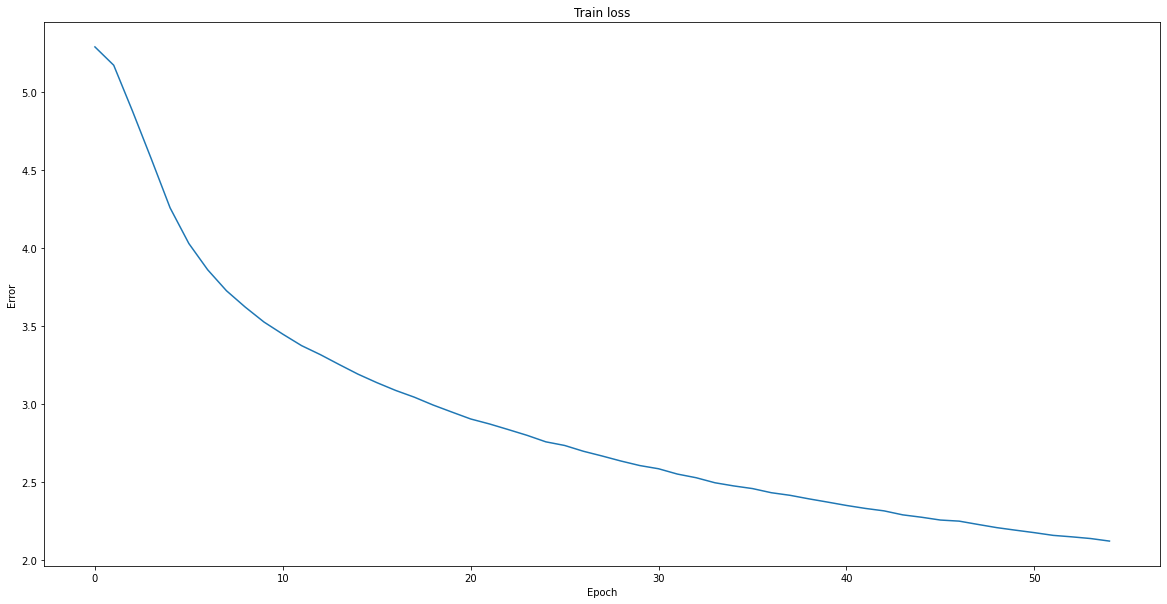

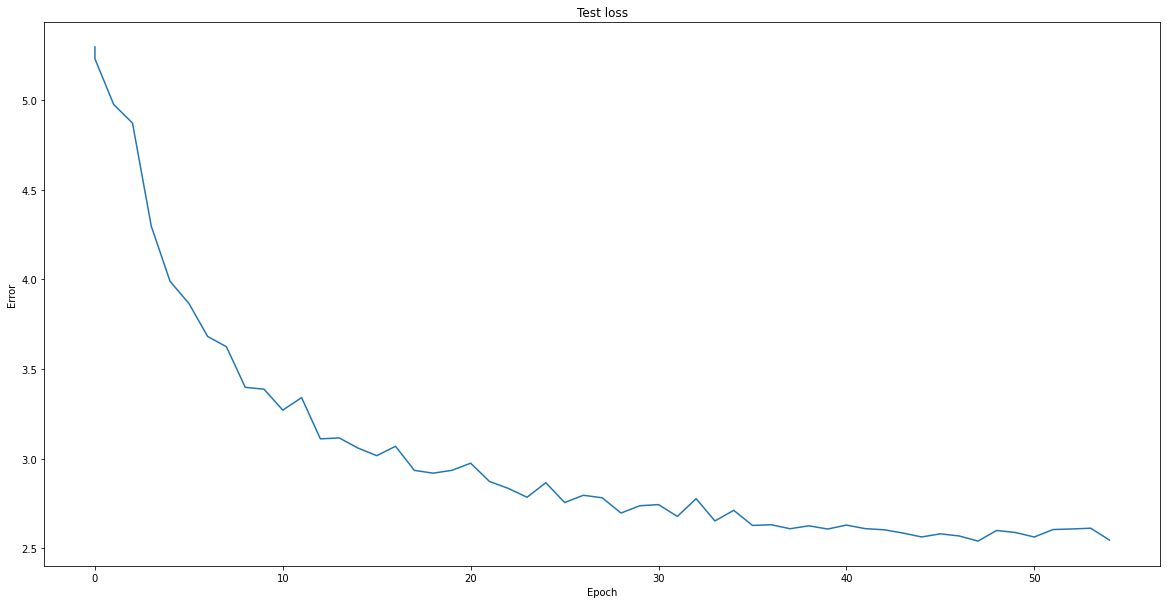

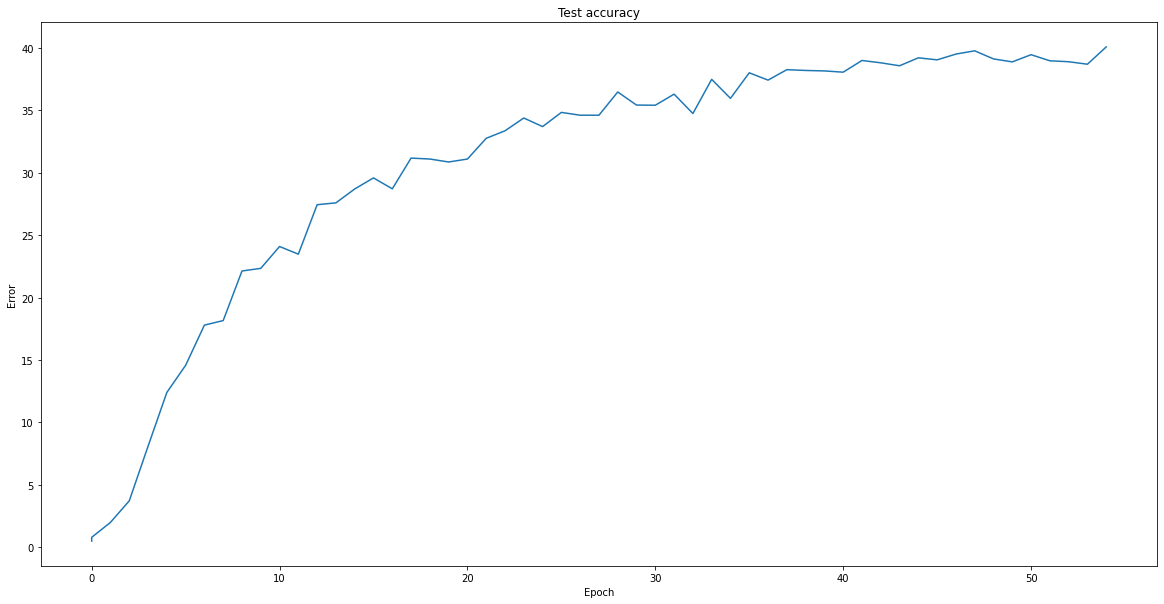

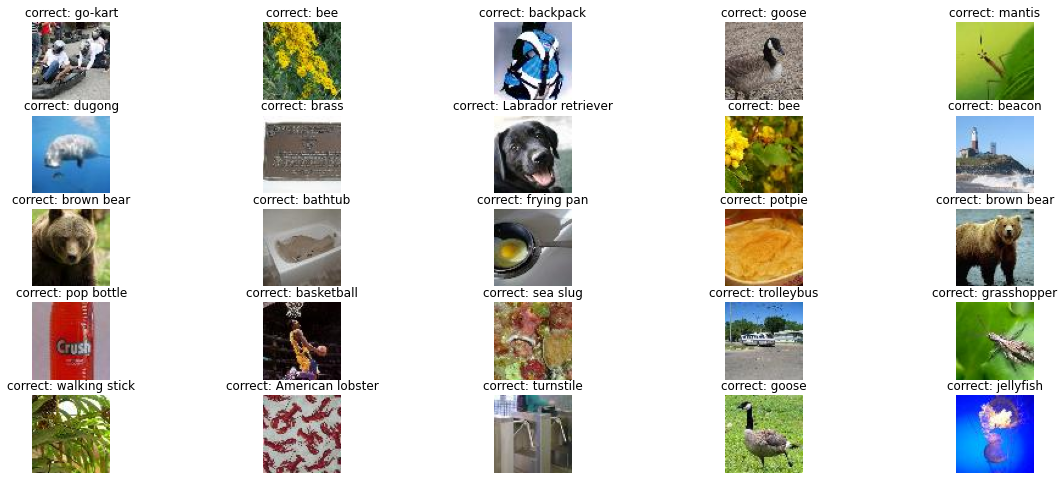

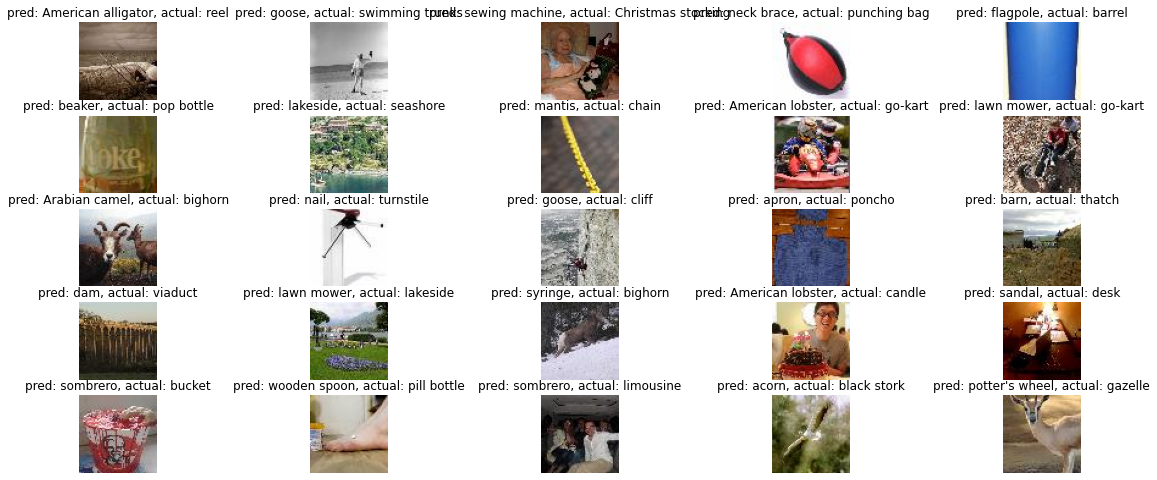

In [10]:
# Play around with these constants, you may find a better setting.
# BEST SOFAR: 0.12
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 60
LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005

IN_CHANNELS = 3
NUM_CLASSES = 200

EXPERIMENT_VERSION = "0.17" # increment this to start a new experiment
LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
name_to_class = {line[1]: line[0] for line in class_names}
class_names = [line[1] for line in class_names]

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)


model = TinyImagenetNet(IN_CHANNELS, NUM_CLASSES).to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(LOG_PATH)
train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)

correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))

pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + '.pkl', (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
    correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])


## TinyImageNet Questions

1. What design that you tried worked the best? How many epochs were you able to run it for? Provide the same information from CIFAR question 1.

The model design that worked the best for me was taking a alex-net type approach. In the model architecture, my building block for the feature extractor consisted of a Convolutional layer, Maxpooling Layer and Batch Normalization. This building block was repeated several times, with appropriate dimensionality reduction at each step. For the classifier, I first started out with a dropout to drop connection to rpevent the model from overfitting, then like any other model, used multiple fully connected layers, gradually decreasing the dimension and using dropouts in between dense layers too. I also experimented with my activation functions. Relu seemed to work the best for the CNN block and leaky relu worked nicely for feature extraction. Also along with tweaking the model infrastructure, I also added normalization on the images as an additonal augmentation startegy. In terms of the hyper-parameters, the model seemed to achieve the benchmark of 40% test accuracy with a leanring rate of 0.01, batch size 256, momentum 0.9. I tried training it for longer periods but noticed that there was next to no progress after epoch number 50. The final metrics for the model were:

Train loss: 
Test Loss
Test Accuracy;


2. Were you able to use larger/deeper networks on TinyImageNet than you used on CIFAR and increase accuracy? If so, why? If not, why not?

The basic model I Uused on CIFAR was stacking convolution layers and then connecting them to a stacked fully connected layer. Those gave me decent results on CIFAR, but when I tried seomthing similar to that model, increasing the number of convolutinal layers, it performed miserably, achieving less than 10% accuracy on testing data after 30 epochs. I feel the reason is similar to what happened between the transition from MNIST to CIFAR, the dataset got complicated. In MNIST, we could extract features just using a simple fully connected layer. Then things got complicated when we switvhed to CIFAR, which required Convolutional Layers for feature extraction. Then from this experiment, we figured out that just using convolutional layers to classify imagenet is not enoough because the features might be complicated. So in order to help convolutional layers perform better and select features better, we add in additional layers, like maxpooling, to select brighter features and also help with downsizing the image. By adding extra support, we were able to somehow get to 40% accuracy on the testing dataset. Therefore, we can attribute to complicated dataset and a simple feature extractor being the reason why extending CifarNet() did not yeild favorable results in this case. 

3. The real ImageNet dataset has significantly larger images. How would you change your network design if the images were twice as large? How about smaller than Tiny ImageNet? How do you think your accuracy would change? This is open-ended, but we want a more thought-out answer than "I'd resize the images" or "I'd do a larger pooling stride." You don't have to write code to test your hypothesis.

So my first approach would be to keep the building block of my network the same, which is (Conv->BatchNorm->MaxPool) and stack multiple of these building blocks together, until I reach the desired performance. Now since the input image sizes is almost 3.5 times more than tiny imagenet, I could see myself using 3.5 more of the building blocks I have used in the current set up. This would mean I would have to be caustious with the number of output channels in each step and downsize my image using maxpooling operations smartly. This is too avoid long training time and at the same time effectively learn important features. But we might run into an issue where we use too many of these blocks and our gradients seem to vanish or explode. So in order to counter than, we will then have to use skip/residual connections to avoid this from happening. So I feel we could replicate these blocks, downsample smartly and add skip connection to get great results on the original image net too

# Turn-in

Download your `hw1.ipynb` and put it in your `uwnet` repository.